In [ ]:
!pip install fastai --upgrade

# Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) is an optimisation algorithm which can be used to minimise a loss function in order to fit a model.
This notebook illustrates the process of SGD by using it to train an image classifier from scratch. This example is taken from the [fast.ai course](https://course.fast.ai/).

The MNIST dataset is used which contains images of handwritten numbers from 0 to 9. The problem is to create a model that can correctly predict which digit a given image is. For this example the dataset is restricted to the digits **3** and **7**.



In [1]:
from fastai.vision.all import *
import seaborn as sns
import pandas as pd

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

## Downloading and preparing the dataset
The dataset contains 'train' and 'valid' folders each of which contain a folder for each of the two classes: **3** and **7**. Create a list of tensors from the MNIST data. We have 6,131 **3s**, and 6,265 **7s**.

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors),len(seven_tensors)

(6131, 6265)

Combine all the images of each class into a single three-dimensional tensor and convert the pixel values to floats between 0 and 1. Looking at the shape of the tensor, we have 6,131 images of 3s that are 28 by 28 pixels.

In [4]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Concatenate the separate class tensors into a single tensor ```train_x``` to hold all the images for training and create the tensor ```train_y``` to hold the training labels or targets (1 for **3s** and 0 for **7s**). The training images and labels are zipped together in ```dset``` because a PyTorch ```Dataset``` is required to return a tuple when indexed.
***Note***: the images have been changed from a 28 by 28 matrix to a 28*28 vector (784 column-long row) where each column represents a pixel value. This is important as it enables us to use matrix multiplication between the input data (pixel values) and parameters to produce an output.

In [5]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
dset = list(zip(train_x,train_y))
dset[0][0].shape, dset[0][1].shape

(torch.Size([784]), torch.Size([1]))

Create the validation dataset in the same manner

In [6]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

We now have two datasets: ```dset``` which contains all the training images and their associated labels, and ```valid_dset``` which contains all the validation images and their labels. The datasets are a list of tuple pairs where the first item is an image represented as a vector of magnitude 784 and the second item is a label, either 0 or 1.

## Building the architecture
The first step is to initialize the parameters. These are the weights or coefficients which will be applied to the data to make class predictions. It is common to initialize the parameters randomly. Create ```weights```, a 784 row vector corresponding to the pixel length of the images, each row has a value randomly initialized using a normal random number distribution which will be applied to the pixel values to predict the class value. ```bias``` is a randomly initialised scalar variable which increases flexibility by allowing the output of the linear equations to be non-zero when the input values are 0.

In [7]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

The graph below shows that each of the 784 weights has been given a random value from a standard normal distribution.

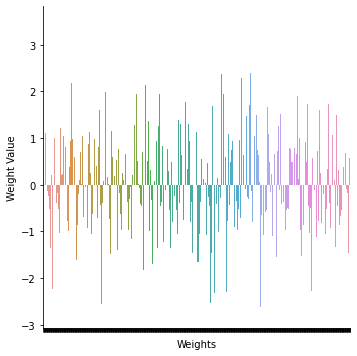

In [8]:
wdf = pd.DataFrame(weights)
wdf.rename(columns={0 :'weight value'}, inplace=True )

g = sns.catplot(x=wdf.index, y='weight value', data=wdf, kind='bar')
(g.set_axis_labels("Weights", "Weight Value")
  .set_xticklabels([]))

### Define the model
Create a function that takes the image vectors as input and multiplies them by the parameters to produce an output which will be used to predict the class value. This simple function is actually the model and since the parameters are randomly intitialised its output won't actually have anything to do with what we want. However, once we compare the outputs with our targets and use some *loss function* to evaluate its performance, we can use SGD to minimise the loss and improve the model.

In [9]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-9.8383],
        [-5.7327],
        [-0.0574],
        ...,
        [-2.0469],
        [-3.5765],
        [ 3.2822]], grad_fn=<AddBackward0>)

Next we set an arbitrary threshold to predict whether a given image is a **3** or a **7**. 

In [10]:
thresh = 0.0
corrects = (preds>thresh).float() == train_y
corrects.float().mean().item()

0.3266376256942749

The graph below shows the distribution of the prediction outputs for each class value. We can see that our arbitrary threshold of 0 in fact does a very poor job of predicting the class values because there is a healthy mix of both **3**s and **7**s on either end of 0. These two nicely distributions are to be expected from intialising the weights using a normal distribution.

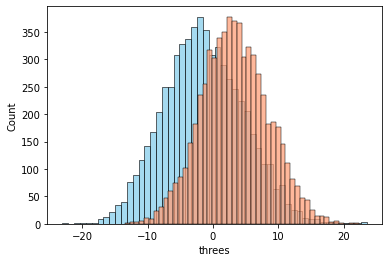

In [11]:
df = pd.DataFrame(preds)
df['threes'] = df[:6131]
df['sevens'] = df[0][6131:]

sns.histplot(df['threes'], color="skyblue")
sns.histplot(df['sevens'], color="lightsalmon")


### Define a *loss function*
The loss function is a means of assessing the the current weight assignments in terms of actual performance.

This loss function takes the outputs from the ```linear1``` model as inputs and compares them to the targets. It measures the distance of each prediction from its target label (i.e. 1 for **3**s and 0 for **7**s) for a batch of predictions and targets and returns an average of these distances. It is our goal to minimise this function by changing the values of the weights. A score of 0 would mean that for some combination of weights applied to a batch of inputs, the model produced outputs that corresponded exactly to the batch's target labels.

One problem with ```mnist_loss``` as currently defined is that it assumes that prediction values are always between 0 and 1 (the above graph shows they are actually ranging from around -20 to 20). The sigmoid method in the loss function transforms the prediction values into values that fall in the domain of 0 to 1 to allow our loss function to work.

![picture](https://drive.google.com/uc?id=1XIjbvnIOU_qfp7tBzXB-w-UsPL8c5ccE)




In [12]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

Creater the ```dl``` ```DataLoader``` which takes our dataset and turns it into an iterator over many batches. The batchs are tuples of tensors representing batches of images and targets. Here we specify a batch size of 256. Processing the dataset in batches like this is the difference between *Gradient Descent* and *Stochastic Gradient Descent*. *Gradient Descent* requires much more computational resources as the entire dataset needs to be processed for one epoch.

In [13]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

### Optimisation
Now that we have a loss function to measure the performance of our model, we need a method that updates the paramaters (weights and bias) to minimise the loss function and improve the model's performance, this is often referred to as stepping. The goal is to adjust the weights until we find the bottom of the loss function and an efficient method for this is to use the gradient of the loss function to tell us which direction to adjust the weights.

![picture](https://drive.google.com/uc?id=1oQUTm8kOQXkOw1i1UzgynWRve1VKOoL_)


```calc_grad``` will process our batches through our model and assess performance using the loss function while tracking the gradient for each weight.

In [14]:
def calc_grad(x_batch, y_batch, model):
  preds = model(x_batch)
  loss = mnist_loss(preds, y_batch)
  loss.backward()

Now all that is left is to update the parameters based on the gradients. It is common to multiply the gradient by a small number called the learning rate to control the size of gradient steps. If it is too large, the algorithm could step beyond the minimum and jump around the function a lot. If it is too small, it will take longer to reach the minimum. Often times the learning rate is set through some trial and error.

The full process is represented in the flow chart below and shows how it is an iterative process.
We initialise the weights and measure the predictions from a model using a loss function, record the gradients and step the parameters toward the bottom of the loss function. We repeat the process with the stepped parameters and continue iterating to improve the predictions until we decide to stop the process.

![picture](https://drive.google.com/uc?id=1raj8HqidkiAIO8pa73xt4lNK_vPeapXn)


The ```train_epoch``` function includes a loop to upgrade the parameters based on the gradients and a learning rate: ```lr```. 

In [15]:
def train_epoch(model, lr, params):
  for x_batch, y_batch in dl:
    calc_grad(x_batch, y_batch, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a **3** or a **7**, we can just check whether it's greater than 0. The ```batch_accuracy``` function does this and returns an accuracy score. ```validate_epoch``` then puts all the batches together and returns an overall score for each epoch.

In [16]:
def batch_accuracy(x_batch, y_batch):
    preds = x_batch.sigmoid()
    correct = (preds>0.5) == y_batch
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Now all thats left is to train the model. First we'll run three epochs and see how the accuracy improves and look at how the distribution of class values (targets) changes. The accuracy improves rapidly in just three epochs and we receive accuracy scores of 52.28%, 65.23% and 85%.

In [17]:
lr = 1.
params = weights, bias
for i in range(3):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.5228 0.6523 0.85 

The graph below shows the distributions of the predictions of the class values being pulled away from each other.

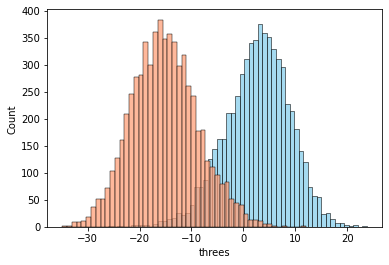

In [18]:
preds = linear1(train_x)
df = pd.DataFrame(preds)
df['threes'] = df[:6131]
df['sevens'] = df[0][6131:]

sns.histplot(df['threes'], color="skyblue")
sns.histplot(df['sevens'], color="lightsalmon")

After 15 more epochs the accuracy improves to over 97%

In [19]:
for i in range(15):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.9242 0.9501 0.957 0.9609 0.9628 0.9648 0.9657 0.9682 0.9687 0.9691 0.9696 0.9701 0.9701 0.9701 0.9701 

We can also see the how the current combination of weights produces predictions which divide the class values into two distinct groups compared to the starting randomly initialised weights. The predictions of images of **7**s which intially had a greater mean than the predictions of **3**s has been pulled to the left into larger negative values. This is because large negative values are converted to 0 or very close to 0 by the sigmoid function. Since we set the target for **7**s to 0, the weights have been optimised to the point where the model will produce large negative prediction values for images of **7**s which corresponds to its target label of 0. Likewise the model will produce large positive prediction values for **3**s which corresponds to its target label of 1 once the sigmoid function is applied.



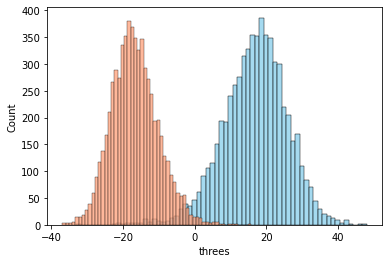

In [20]:
preds = linear1(train_x)
df = pd.DataFrame(preds)
df['threes'] = df[:6131]
df['sevens'] = df[0][6131:]

sns.histplot(df['threes'], color="skyblue")
sns.histplot(df['sevens'], color="lightsalmon")

### Distribution of predictions using randomly initialised weights
![picture](https://drive.google.com/uc?id=1eDzD7W5GqC55Ph5H-Gg5XTPyUvHR7fCg)